In [541]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

E: Could not get lock /var/lib/dpkg/lock-frontend. It is held by process 402791 (apt)
N: Be aware that removing the lock file is not a solution and may break your system.
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), is another process using it?


In [77]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [78]:
train_path = '/home/train.csv'
test_path  = '/home/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [79]:
# data, data_test shape
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape) # train : target O, test : target X

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [80]:
# train/test 구분을 위한 New Column - 'is_test'
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test]) # train + test 

In [81]:
# 주요 칼럼 리스트
### 등기신청일자 
important_columns = [
    '시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)',
    '계약년월', '계약일', '층', '건축년도', '도로명',
    '거래유형', '중개사소재지', 'target','is_test'
]

# 주요 칼럼만 남긴 데이터프레임
filtered_concat = concat[important_columns]

# 각 열의 결측치 수 확인
missing_counts_filtered = filtered_concat.isnull().sum()

print("각 열의 결측치 수 (필터링된 데이터프레임):\n", missing_counts_filtered)

각 열의 결측치 수 (필터링된 데이터프레임):
 시군구           0
번지          227
본번           75
부번           75
아파트명       2136
전용면적(㎡)       0
계약년월          0
계약일           0
층             0
건축년도          0
도로명           0
거래유형          0
중개사소재지        0
target     9272
is_test       0
dtype: int64


In [82]:
# '힐스테이트 서초 젠트리스' 아파트명의 '본번', '부번' 채우기
# 본번, 부번 null 값
filtered_concat.loc[(filtered_concat['본번'].isna()) & (filtered_concat['아파트명'] == '힐스테이트 서초 젠트리스'), '본번'] = 10
filtered_concat.loc[(filtered_concat['부번'].isna()) & (filtered_concat['아파트명'] == '힐스테이트 서초 젠트리스'), '부번'] = 12

# '서초포레스타2단지' 아파트명의 '본번' 채우기, '부번' 없음 
# 본번 0 값
filtered_concat.loc[(filtered_concat['본번'] == 0) & (filtered_concat['아파트명'] == '서초포레스타2단지'), '본번'] = 45

In [83]:
# '서초포레스타2단지' 아파트명의 '번지' 채우기
filtered_concat.loc[(filtered_concat['번지'].isna()) & (filtered_concat['아파트명'] == '서초포레스타2단지'), '번지'] = 384

# '힐스테이트 서초 젠트리스' 아파트명의 '번지' 값을 557로 채워넣기
filtered_concat.loc[(filtered_concat['번지'].isna()) & (filtered_concat['아파트명'] == '힐스테이트 서초 젠트리스'), '번지'] = 557

In [84]:
filtered_concat.isnull().sum()

시군구           0
번지            0
본번            0
부번            0
아파트명       2136
전용면적(㎡)       0
계약년월          0
계약일           0
층             0
건축년도          0
도로명           0
거래유형          0
중개사소재지        0
target     9272
is_test       0
dtype: int64

In [85]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
filtered_concat['구'] = filtered_concat['시군구'].map(lambda x : x.split()[1])
filtered_concat['동'] = filtered_concat['시군구'].map(lambda x : x.split()[2])
del filtered_concat['시군구']

filtered_concat['계약년'] = filtered_concat['계약년월'].astype('str').map(lambda x : x[:4])
filtered_concat['계약월'] = filtered_concat['계약년월'].astype('str').map(lambda x : x[4:])
del filtered_concat['계약년월']

In [86]:
filtered_concat.isnull().sum()

번지            0
본번            0
부번            0
아파트명       2136
전용면적(㎡)       0
계약일           0
층             0
건축년도          0
도로명           0
거래유형          0
중개사소재지        0
target     9272
is_test       0
구             0
동             0
계약년           0
계약월           0
dtype: int64

In [87]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
filtered_concat['본번'] = filtered_concat['본번'].astype('str')
filtered_concat['부번'] = filtered_concat['부번'].astype('str')

In [88]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in filtered_concat.columns:
    if pd.api.types.is_numeric_dtype(filtered_concat[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '계약일', '층', '건축년도', 'target', 'is_test']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', '거래유형', '중개사소재지', '구', '동', '계약년', '계약월']


In [89]:
filtered_concat

,번지,본번,부번,아파트명,전용면적(㎡),계약일,층,건축년도,도로명,거래유형,중개사소재지,target,is_test,구,동,계약년,계약월
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,-,-,124000.0,0,강남구,개포동,2017,12
1,658-1,658.0,1.0,개포6차우성,79.97,22,4,1987,언주로 3,-,-,123500.0,0,강남구,개포동,2017,12
2,658-1,658.0,1.0,개포6차우성,54.98,28,5,1987,언주로 3,-,-,91500.0,0,강남구,개포동,2017,12
3,658-1,658.0,1.0,개포6차우성,79.97,3,4,1987,언주로 3,-,-,130000.0,0,강남구,개포동,2018,01
4,658-1,658.0,1.0,개포6차우성,79.97,8,2,1987,언주로 3,-,-,117000.0,0,강남구,개포동,2018,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,816,816.0,0.0,신내우디안1단지,84.65,19,13,2014,신내역로1길 85,직거래,-,NaN,1,중랑구,신내동,2023,07
9268,816,816.0,0.0,신내우디안1단지,84.62,25,12,2014,신내역로1길 85,중개거래,서울 중랑구,NaN,1,중랑구,신내동,2023,07
9269,816,816.0,0.0,신내우디안1단지,101.65,27,12,2014,신내역로1길 85,중개거래,서울 중랑구,NaN,1,중랑구,신내동,2023,08
9270,816,816.0,0.0,신내우디안1단지,84.94,2,18,2014,신내역로1길 85,중개거래,서울 중랑구,NaN,1,중랑구,신내동,2023,09


In [90]:
# 범주형 변수에 대한 보간
filtered_concat[categorical_columns] = filtered_concat[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
filtered_concat[continuous_columns] = filtered_concat[continuous_columns].interpolate(method='linear', axis=0)

In [91]:
filtered_concat.isnull().sum()

번지         0
본번         0
부번         0
아파트명       0
전용면적(㎡)    0
계약일        0
층          0
건축년도       0
도로명        0
거래유형       0
중개사소재지     0
target     0
is_test    0
구          0
동          0
계약년        0
계약월        0
dtype: int64

In [92]:
filtered_concat.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약일', '층', '건축년도', '도로명', '거래유형',
       '중개사소재지', 'target', 'is_test', '구', '동', '계약년', '계약월'],
      dtype='object')

In [93]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = filtered_concat.query('is_test==0')
dt_test = filtered_concat.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 16) (9272, 16)


In [22]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

In [23]:
# 연속형 변수와 범주형 변수 분리
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# 범주형 변수에 대해 레이블 인코딩 수행
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()

    # 데이터 타입을 문자열로 변환
    dt_train[col] = dt_train[col].astype(str)
    dt_test[col] = dt_test[col].astype(str)

    # Label-Encoding을 fit
    lbl.fit(dt_train[col])
    dt_train[col] = lbl.transform(dt_train[col])
    label_encoders[col] = lbl  # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
        if label not in lbl.classes_:  # unseen label 데이터인 경우
            lbl.classes_ = np.append(lbl.classes_, label)  # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col])

print(dt_train)
print(dt_test)

연속형 변수: ['전용면적(㎡)', '계약일', '층', '건축년도', 'target']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', '거래유형', '중개사소재지', '구', '동', '계약년', '계약월']


100%|██████████| 11/11 [00:02<00:00,  3.72it/s]

           번지    본번   부번  아파트명  전용면적(㎡)  계약일   층  건축년도   도로명  거래유형  중개사소재지  \
0        4732  1148    1   328    79.97    8   3  1987  6176     0       0   
1        4732  1148    1   328    79.97   22   4  1987  6176     0       0   
2        4732  1148    1   328    54.98   28   5  1987  6176     0       0   
3        4732  1148    1   328    79.97    3   4  1987  6176     0       0   
4        4732  1148    1   328    79.97    8   2  1987  6176     0       0   
...       ...   ...  ...   ...      ...  ...  ..   ...   ...   ...     ...   
1118817  3082   821    0   215    59.94   12  11  1998  4816     0       0   
1118818  3082   821    0   215    59.94   25  10  1998  4816     0       0   
1118819  3082   821    0   215    84.83   31  20  1998  4816     0       0   
1118820  3082   821    0   215    84.83   15   8  1998  4816     0       0   
1118821   404   100  280  2177    52.46   10   5  1981  4783     0       0   

           target   구    동  계약년  계약월  
0        124000.0   0   

In [24]:
assert dt_train.shape[1] == dt_test.shape[1] 

In [25]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [26]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=38, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [565]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 6758.76420148164


In [27]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
## 번지/부번/본번 결측치 채운 결과
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 6777.108852965295


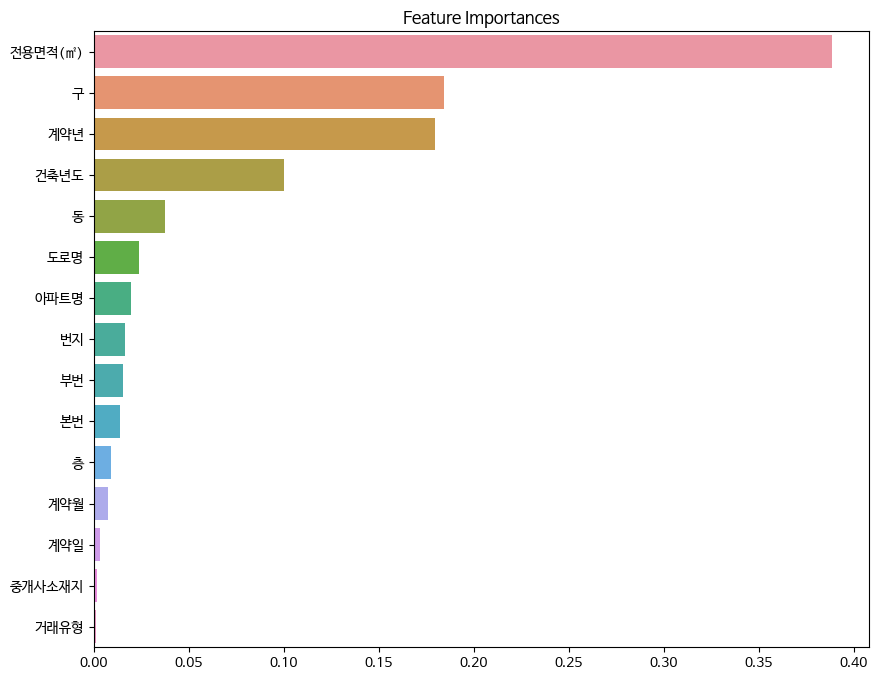

In [518]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [519]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('base_model1.pkl', 'wb') as f:
    pickle.dump(model, f)

In [520]:
# 저장된 모델을 불러옵니다.
with open('base_model1.pkl', 'rb') as f:
    model = pickle.load(f)

In [521]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 96.6 ms, sys: 12.1 ms, total: 109 ms
Wall time: 28 ms


In [522]:
real_test_pred  

array([205345.86842105, 317345.26315789, 345000.        , ...,
        77076.31578947,  69618.42105263,  69975.65789474])

In [523]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('/home/output3.csv', index=False)